In [ ]:
!pip install botorch

     |████████████████████████████████| 399kB 7.8MB/s 
     |████████████████████████████████| 501kB 14.8MB/s 


In [2]:
import pandas as pd #Python Data Analysis Library 
import numpy as np #Python Scientific Library 
from scipy.stats import sem
from scipy import stats

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model

import matplotlib.pyplot as plt
import copy

from math import ceil, floor
from collections import defaultdict, Counter

import torch
from torch import rand, randn, cat, stack
from botorch.test_functions.synthetic import Hartmann

# General Volume vs. Bias and vs. Loss Hypothesis Testing

*   Sample $X_S, X_{S'}$ from the same distribution over the feature space: uniform, normal, DPP
*   Test the following hypotheses empirically: 
1. $\text{Vol}(X_S) \geq \text{Vol}(X_{S'}) \implies |X_S^+ - X^+| \leq |X_{S'}^+ - X^+|$
2. $\text{Vol}(X_S) \geq \text{Vol}(X_{S'}) \implies L(X_S^+) \leq L(X_{S'}^+)$

For a noise-less linear, polynomial and sinu-soidal true target function, respectively.

In [20]:
def compute_volume(S1, S2, d=1, log=False):
    X = np.append(S1, S2)

    S1 = S1.reshape(-1, d)
    S2 = S2.reshape(-1, d)
    X = X.reshape(-1, d)

    if not log and d > 10 :
        print("Using log of volume for dimension > 10 to ensure numerical stability.")
        log = True

    if log:
        v1 = np.linalg.slogdet(S1.T @ S1)[1]
        v2 = np.linalg.slogdet(S2.T @ S2)[1]
        v_all = np.linalg.slogdet(X.T @ X)[1]

    else:
        v1 = np.sqrt(np.linalg.det(S1.T @ S1) + 1e-8)
        v2 = np.sqrt(np.linalg.det(S2.T @ S2) + 1e-8)
        v_all = np.sqrt(np.linalg.det(X.T @ X) + 1e-8)

    return v1, v2, v_all



def compute_bias(S1, S2, d=1):
    X = np.append(S1, S2)

    S1 = S1.reshape(-1, d)
    S2 = S2.reshape(-1, d)
    X = X.reshape(-1, d)

    # print("data matrices shapes:", S1.shape, S2.shape, X.shape)
    XI_S1 = np.zeros( (X.shape[0], X.shape[0]) )
    XI_S2 = np.zeros( (X.shape[0], X.shape[0]) )

    IS1 = np.append(np.ones(s), np.zeros(s))
    IS2 = np.append(np.zeros(s), np.ones(s))
    for i in range(X.shape[0]):
        XI_S1[i,i] = IS1[i]
        XI_S2[i,i] = IS2[i]

    XI_S1 = XI_S1 @ X
    XI_S2 = XI_S2 @ X

    S1_pinv, S2_pinv = np.linalg.pinv(XI_S1), np.linalg.pinv(XI_S2)
    X_pinv = np.linalg.pinv(X)
    return np.linalg.norm(S1_pinv - X_pinv), np.linalg.norm(S2_pinv - X_pinv)


def compute_loss(S1, S2, f, d, param=False, Lambda=0):
    assert Lambda >= 0

    y1 = np.asarray([f(s1) for s1 in S1 ])
    y2 = np.asarray([f(s2) for s2 in S2 ])
    # y1 = f(S1)
    # y2 = f(S2)
    
    X = np.append(S1, S2)
    y = np.append(y1, y2).reshape(-1, 1)

    S1 = S1.reshape(-1, d)
    S2 = S2.reshape(-1, d)
    X = X.reshape(-1, d)

    if Lambda != 0:
        XI_S1_pinv = np.linalg.inv(S1.T @ S1 + Lambda * np.eye(d)) @ S1.T
        XI_S2_pinv = np.linalg.inv(S2.T @ S2 + Lambda * np.eye(d)) @ S2.T
        X_pinv = np.linalg.inv(X.T @ X + Lambda * np.eye(d)) @ X.T

    else:
        XI_S1_pinv, XI_S2_pinv = np.linalg.pinv(S1), np.linalg.pinv(S2)
        X_pinv = np.linalg.pinv(X)

    w_S1 = XI_S1_pinv @ y1
    w_S2 = XI_S2_pinv @ y2
    w_X =  X_pinv @ y

    loss1 = np.linalg.norm( X @ w_S1 - y )
    loss2 = np.linalg.norm( X @ w_S2 - y )
    loss = np.linalg.norm( X @ w_X - y )
    if not param:
        return loss1/len(y), loss2/len(y), loss/len(y)
    else:
        return loss1/len(y), loss2/len(y), loss/len(y), w_S1, w_S2
    

def compute_loss_dual(S1, S2, f, d, weight=False, Lambda=0):
    assert Lambda >= 0
    y1 = np.asarray([f(s1) for s1 in S1 ])
    y2 = np.asarray([f(s2) for s2 in S2 ])
    # y1 = f(S1)
    # y2 = f(S2)
    
    X = np.append(S1, S2)
    y = np.append(y1, y2).reshape(-1, 1)

    S1 = S1.reshape(-1, d)
    S2 = S2.reshape(-1, d)
    X = X.reshape(-1, d)

    if Lambda != 0:
        a1 = np.linalg.inv(S1 @ S1.T + Lambda *np.eye(len(S1))) @ y1
        a2 = np.linalg.inv(S2 @ S2.T + Lambda *np.eye(len(S2))) @ y2
        a_all = np.linalg.inv(X@ X.T + Lambda *np.eye(len(X))) @ y
    else:
        a1, a2 = np.linalg.inv(S1 @ S1.T) @ y1, np.linalg.inv(S2 @ S2.T) @ y2
        a_all = np.linalg.inv(X @ X.T) @ y


    loss1 = np.linalg.norm( (X @ S1.T)@ a1 - y)
    loss2 = np.linalg.norm( (X @ S2.T)@ a2 - y)
    loss = np.linalg.norm( (X @ X.T) @ a_all - y)

    if not weight:
        return loss1/len(y), loss2/len(y), loss/len(y)
    else:
        return loss1/len(y), loss2/len(y), loss/len(y), a1, a2


## Volume vs bias (gaussian and uniform) experiments and plot

In [ ]:
ds = [1, 2, 5, 10]
M = 500

s_values = np.linspace(10, 500, 20)
gauss_counts = []
for d in ds:
    counts = []
    for s in s_values:
        count = 0.0
        s = int(s)
        for _ in range(M):
            S1 = np.random.normal(0, 1, (s,d))
            S2 = np.random.normal(0, 1, (s,d))
            
            v1, v2, v_all = compute_volume(S1, S2, d)
            (b1, b2) = compute_bias(S1, S2, d)

            if (v1 >= v2 and b1 <= b2) or (v1<=v2 and b1 >= b2):
                count +=1
        counts.append(count / M)
    gauss_counts.append(counts)
    
uniform_counts = []
for d in ds:
    counts = []
    for s in s_values:
        count = 0.0
        s = int(s)
        for _ in range(M):
            S1 = np.random.uniform(0, 1, (s,d))
            S2 = np.random.uniform(0, 1, (s,d))
            
            v1, v2, v_all = compute_volume(S1, S2, d)
            (b1, b2) = compute_bias(S1, S2, d)

            if (v1 >= v2 and b1 <= b2) or (v1<=v2 and b1 >= b2):
                count +=1
        counts.append(count / M)
    uniform_counts.append(counts)

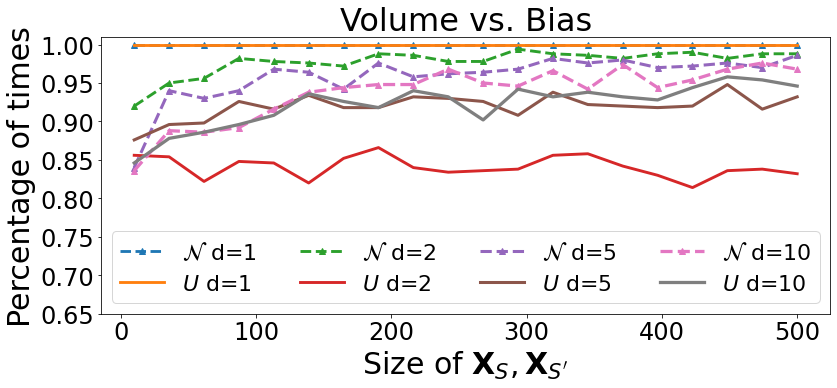

In [ ]:
plt.figure(figsize=(12, 5.5))

for i, d in enumerate(ds):

    counts = gauss_counts[i]
    plt.plot(s_values, counts, linestyle = 'dashed', marker='^', label= "$\mathcal{N}$ d="+str(d), linewidth=np.log(d+16))
    
    counts = uniform_counts[i]
    plt.plot(s_values, counts, linestyle = 'solid', label= "$U$ d="+str(d), linewidth=np.log(d+16))

plt.legend(ncol=4, loc='lower center', fontsize=22)
plt.ylabel("Percentage of times", fontsize=30)
plt.xlabel("Size of $\mathbf{X}_S, \mathbf{X}_{S'}$", fontsize=30)
plt.ylim(0.65)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.title('Volume vs. Bias', fontsize=32)
plt.tight_layout()
plt.show()

## Volume vs loss (gaussian and uniform) sinusoidal functions

In [ ]:
ds = [1, 2, 5, 10]
M = 500
s_values = np.linspace(10, 500, 20)

gauss_counts_loss = []
uniform_counts_loss = []
for d in ds:

    coefs_in = np.random.uniform(0, 2, (1, d))
    coefs_out = np.random.uniform(-1, 1, (1, d))

    fcn = lambda x: np.sin(np.dot(coefs_in, x))

    counts = []
    v1s, v2s, vs = [], [], []
    for s in s_values:
        count = 0.0
        s = int(s)
        V1, V2, V = 0,0,0
        for _ in range(M):
            S1 = np.random.normal(0, 1, (s, d))
            S2 = np.random.normal(0, 1, (s, d))

            v1, v2, v_all = compute_volume(S1, S2, d)
            l1, l2, loss = compute_loss(S1, S2, fcn, d)
            if (v1 >= v2 and l1 <= l2) or (v1 <= v2 and l1 >= l2):
                count += 1
        counts.append(count/M)
    gauss_counts_loss.append(counts)

    counts = []
    v1s, v2s, vs = [], [], []
    for s in s_values:
        count = 0.0
        s = int(s)

        V1, V2, V = 0,0,0
        for _ in range(M):
            S1 = np.random.uniform(0, 1, (s, d))
            S2 = np.random.uniform(0, 1, (s, d))

            v1, v2, v_all = compute_volume(S1, S2, d)
            l1, l2, loss = compute_loss(S1, S2, fcn, d)
            if (v1 >= v2 and l1 <= l2) or (v1 <= v2 and l1 >= l2):
                count += 1

        counts.append(count/M)
    uniform_counts_loss.append(counts)

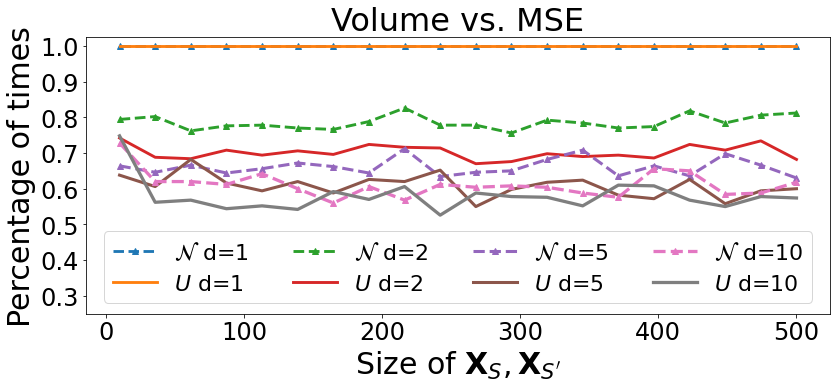

In [ ]:
plt.figure(figsize=(12, 5.5))

for i, d in enumerate(ds):
    counts = gauss_counts_loss[i]
    plt.plot(s_values, counts, linestyle = 'dashed', marker='^', label= "$\mathcal{N}$ d="+str(d), linewidth=np.log(d+16))
    
    counts = uniform_counts_loss[i]
    plt.plot(s_values, counts, linestyle = 'solid', label= "$U$ d="+str(d), linewidth=np.log(d+16))

plt.legend(ncol=4, loc='lower center', fontsize=22)
plt.ylabel("Percentage of times", fontsize=30)
plt.xlabel("Size of $\mathbf{X}_S, \mathbf{X}_{S'}$", fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.title('Volume vs. MSE', fontsize=32)
plt.ylim(0.25)
# plt.hlines(xmin=0 ,xmax = 500,  y=0.5, linewidth=5, linestyle='dotted', color='k')
plt.tight_layout()
plt.show()

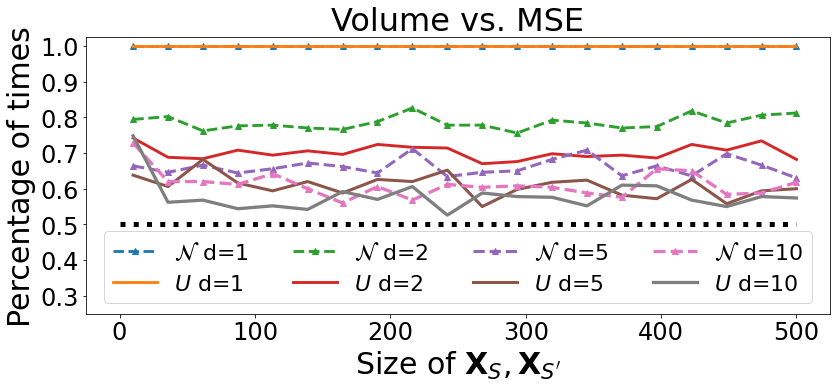

In [ ]:
plt.figure(figsize=(12, 5.5))

for i, d in enumerate(ds):
    counts = gauss_counts_loss[i]
    plt.plot(s_values, counts, linestyle = 'dashed', marker='^', label= "$\mathcal{N}$ d="+str(d), linewidth=np.log(d+16))
    
    counts = uniform_counts_loss[i]
    plt.plot(s_values, counts, linestyle = 'solid', label= "$U$ d="+str(d), linewidth=np.log(d+16))

plt.legend(ncol=4, loc='lower center', fontsize=22)
plt.ylabel("Percentage of times", fontsize=30)
plt.xlabel("Size of $\mathbf{X}_S, \mathbf{X}_{S'}$", fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.title('Volume vs. MSE', fontsize=32)
plt.ylim(0.25)
plt.hlines(xmin=0 ,xmax = 500,  y=0.5, linewidth=5, linestyle='dotted', color='k')
plt.tight_layout()
plt.show()

## Volume decomposition lemma

In [ ]:
d = 10
s = 30
S1 = np.random.normal(0, 0.5, (s,d))
S1 = S1.reshape(-1, d)

M = 5
for m in range(M):
    S2 = np.random.normal(0.5, 1, (s,d))
    X = np.append(S1, S2)

    S2 = S2.reshape(-1, d)
    X = X.reshape(-1, d)

    G1, G2 = S1.T@S1 ,S2.T@S2

    # v1, v2, v_all = compute_volume(S1, S2, d)
    gg_v1 = np.linalg.det((np.eye(d) + np.linalg.inv(G1) @ G2 )) 
    gg_v2 = np.linalg.det((np.eye(d) + np.linalg.inv(G2) @ G1 ))

    _, log_V_square = np.linalg.slogdet(X.T @ X)
    _, log_V1_square = np.linalg.slogdet(S1.T @ S1)
    _, log_V2_square = np.linalg.slogdet(S2.T @ S2)

    log_V = log_V_square / 2
    log_V1 = log_V1_square / 2
    log_V2 = log_V2_square / 2

    _, log_gg_v1 = np.linalg.slogdet((np.eye(d) + np.linalg.inv(G1) @ G2 ))
    _, log_gg_v2 = np.linalg.slogdet((np.eye(d) + np.linalg.inv(G2) @ G1 ))


18.29411312317082 18.29411312317082 18.29411312317082
18.006575395074204 18.006575395074204 18.006575395074204
17.726805497832956 17.726805497832956 17.72680549783296
17.41015065519948 17.41015065519948 17.41015065519948
17.54344462134015 17.54344462134015 17.54344462134015


## $V \gg V_S, V_{S'}$

In [ ]:
from scipy.stats import sem

v1_mean, v1_sem = [], []
v2_mean, v2_sem = [], []
v_mean, v_sem = [], []

Ds = list(range(10, 100, 20))
for d in Ds:
    s = 50 * d
    v1s, v2s, vs = [], [], []
    for _ in range(10):
        S1 = np.random.normal(0, 1, (s, d))
        S2 = np.random.normal(0, 1, (s*2, d))
        v1, v2, v_all = compute_volume(S1, S2, d, log=True)

        v1s.append(v1)
        v2s.append(v2)
        vs.append(v_all)

    v1_mean.append(np.mean(v1s))
    v1_sem.append(sem(v1s))
    v2_mean.append(np.mean(v2s))
    v2_sem.append(sem(v2s))
    v_mean.append(np.mean(vs))
    v_sem.append(sem(vs))


normal_VV_dict = {'v':(v_mean, v_sem), 'v1':(v1_mean, v1_sem), 'v2':(v2_mean, v2_sem)}

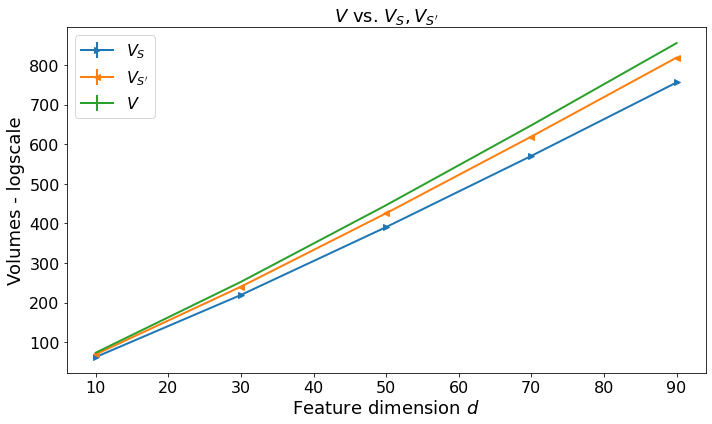

In [ ]:

plt.figure(figsize=(10, 6))
plt.title("$V$ vs. $V_S, V_{S'}$", fontsize=18)
plt.errorbar(x=Ds, y=v1_mean, marker='>', yerr=v1_sem, label= "$V_S$", linewidth=2)
plt.errorbar(x=Ds, y=v2_mean, marker='<', yerr=v2_sem, label= "$V_{S'}$", linewidth=2)
plt.errorbar(x=Ds, y=v_mean, yerr=v_sem, label= "$V$", linewidth=2)
plt.legend(fontsize=16)

plt.ylabel('Volumes - logscale', fontsize=18)
plt.xlabel('Feature dimension $d$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import sem

v1_mean, v1_sem = [], []
v2_mean, v2_sem = [], []
v_mean, v_sem = [], []

Ds = list(range(10, 100, 20))
for d in Ds:
    s = 50 * d
    v1s, v2s, vs = [], [], []
    for _ in range(10):
        S1 = np.random.uniform(0, 1, (s, d))
        S2 = np.random.uniform(0, 1, (s*2, d))
        v1, v2, v_all = compute_volume(S1, S2, d, log=True)

        v1s.append(v1)
        v2s.append(v2)
        vs.append(v_all)

    v1_mean.append(np.mean(v1s))
    v1_sem.append(sem(v1s))
    v2_mean.append(np.mean(v2s))
    v2_sem.append(sem(v2s))
    v_mean.append(np.mean(vs))
    v_sem.append(sem(vs))


uniform_VV_dict = {'v':(v_mean, v_sem), 'v1':(v1_mean, v1_sem), 'v2':(v2_mean, v2_sem)}

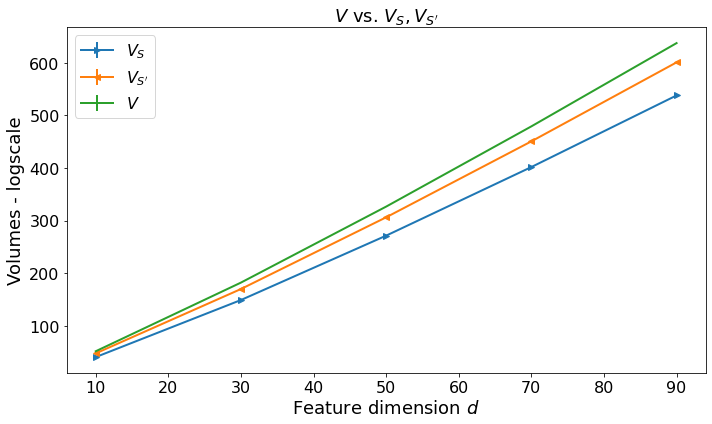

In [ ]:

plt.figure(figsize=(10, 6))
plt.title("$V$ vs. $V_S, V_{S'}$", fontsize=18)
plt.errorbar(x=Ds, y=v1_mean, marker='>', yerr=v1_sem, label= "$V_S$", linewidth=2)
plt.errorbar(x=Ds, y=v2_mean, marker='<', yerr=v2_sem, label= "$V_{S'}$", linewidth=2)
plt.errorbar(x=Ds, y=v_mean, yerr=v_sem, label= "$V$", linewidth=2)
plt.legend(fontsize=16)

plt.ylabel('Volumes - logscale', fontsize=18)
plt.xlabel('Feature dimension $d$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.show()

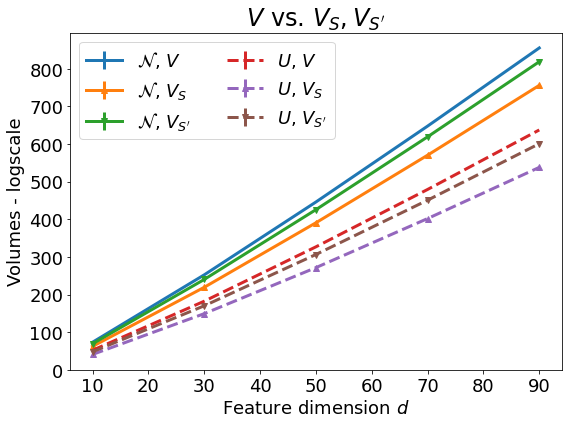

In [ ]:
plt.figure(figsize=(8, 6))

for key, label, marker in zip(['v', 'v1', 'v2'], ['$V$', '$V_S$','$V_{S\'}$'] ,['', '^', 'v'] ):
    v_mean, v_sem = normal_VV_dict[key]
    plt.errorbar(x=Ds, y=v_mean, linestyle='solid', marker=marker, yerr=v_sem, label="$\mathcal{N}$, " + label, linewidth=3)


for key, label, marker in zip(['v', 'v1', 'v2'], ['$V$', '$V_S$','$V_{S\'}$'],['', '^', 'v']  ):
    v_mean, v_sem = uniform_VV_dict[key]
    plt.errorbar(x=Ds, y=v_mean, linestyle='dashed', marker=marker, yerr=v_sem, label="$U$, "+ label, linewidth=3)

plt.legend(ncol=2, fontsize=18)

plt.ylabel('Volumes - logscale', fontsize=18)
plt.xlabel('Feature dimension $d$', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("$V$ vs. $V_S, V_{S'}$", fontsize=24)

plt.tight_layout()
plt.show()

## Adversarial examples for V1 > V2 and yet we can have
     - L1 > L2
     - L1 < L2
by constructing labels y for each of the two cases appropriately.

In [ ]:
# For the saved S1, S2

# TO get L1 > L2
y1 = np.asarray([np.exp(1*s1[1]) for s1 in S1])
y2 = np.zeros(len(S2))

# To get L1 < L2
y1 = np.ones(len(S1))
y2 = np.zeros(len(S2))

In [ ]:

def get_loss(S1, y1, S2, y2):
    d = S1.shape[1]
    assert S1.shape[1] == S2.shape[1]
    assert len(S1) == len(y1) and len(S2) == len(y2)
    X = np.append(S1, S2)
    y = np.append(y1, y2).reshape(-1, 1)

    S1 = S1.reshape(-1, d)
    S2 = S2.reshape(-1, d)
    X = X.reshape(-1, d)

    XI_S1_pinv, XI_S2_pinv = np.linalg.pinv(S1), np.linalg.pinv(S2)

    w_S1 = XI_S1_pinv @ y1
    w_S2 = XI_S2_pinv @ y2

    X_pinv = np.linalg.pinv(X)
    w_X =  X_pinv @ y
    l1 = np.linalg.norm( X @ w_S1 - y )
    l2 = np.linalg.norm( X @ w_S2 - y )
    loss = np.linalg.norm( X @ w_X - y )    
    return l1, l2, loss

d = 2
s = 3

for m in range(1000):
    S1 = np.random.uniform(0, 1, (s, d))
    S2 = np.random.uniform(0, 1, (s, d))

    v1, v2, v_all = compute_volume(S1, S2, d)
    
    # first y set
    if v1 > v2:
        y1 = np.zeros(len(S1))
        y2 = np.asarray([np.exp(10*s2[1]) for s2 in S2])
    else:
        y1 = np.asarray([np.exp(10*s1[1]) for s1 in S1])
        y2 = np.zeros(len(S2))

    l1, l2, loss = get_loss(S1, y1, S2, y2)
    flag1 = l1 > l2
    if v1 > v2:
        y1 = np.asarray([np.exp(10*s1[1]) for s1 in S1])
        y2 = np.zeros(len(S2))
    else:
        y1 = np.zeros(len(S1))
        y2 = np.asarray([np.exp(10*s2[1]) for s2 in S2])

    l1_, l2_, loss = get_loss(S1, y1, S2, y2)
    flag2 = l1_ < l2_

    if flag1 == flag2:
        print(S1)
        print(S2)
        print(v1, v2, v1 > v2)
        print(l1, l2)
        print(l1_, l2_)
        break

[[0.41978497 0.82836752]
 [0.8393158  0.24545882]
 [0.8544813  0.72294841]]
[[0.40205988 0.44985846]
 [0.36588236 0.33433118]
 [0.79521338 0.34753677]]
0.8196715905001557 0.26014494130183635 True
244.0373684548467 452.6590579231335
11930.853949388587 10268.77510682217


In [ ]:

X = np.append(S1, S2)
y = np.append(y1, y2).reshape(-1, 1)

S1 = S1.reshape(-1, d)
S2 = S2.reshape(-1, d)
X = X.reshape(-1, d)

XI_S1_pinv, XI_S2_pinv = np.linalg.pinv(S1), np.linalg.pinv(S2)

w_S1 = XI_S1_pinv @ y1
w_S2 = XI_S2_pinv @ y2

X_pinv = np.linalg.pinv(X)
w_X =  X_pinv @ y

l1 = np.linalg.norm( X @ w_S1 - y )
l2 = np.linalg.norm( X @ w_S2 - y )
loss = np.linalg.norm( X @ w_X - y )

print(l1, l2, loss)
print("v1 > v2:", v1 > v2, "and l1 < l2:", l1 < l2)

28.030326803426572 27.92391017355789 3.881655232069283
v1 > v2: False and l1 < l2: False


In [ ]:
np.savetxt('S1.txt', S1)
np.savetxt('S2.txt', S2)

## Bounded Distortion

In [22]:

def compute_X_tilde_and_counts(X, omega):
    """
    Compresses the original feature matrix X to  X_tilde with the specified omega.

    Returns:
       X_tilde: compressed np.ndarray
       cubes: a dictionary of cubes with the respective counts in each dcube
    """
    D = X.shape[1]
    assert 0 < omega <= 1, "omega must be within range [0,1]."
    m = ceil(1.0 / omega) # number of intervals for each dimension

    cubes = Counter() # a dictionary to store the freqs
    # key: (1,1,..)  a d-dimensional tuple, each entry between [0, m-1]
    # value: counts

    Omega = defaultdict(list)

    # a dictionary to store cubes of not full size
    for x in X:
        cube = []
        for d, xd in enumerate(x):
            d_index = floor(xd / omega)
            cube.append(d_index)

        cube_key = tuple(cube)
        cubes[cube_key] += 1

        Omega[cube_key].append(x)

        '''
        if cube_key in Omega:
            
            # Implementing mean() to compute the average of all rows which fall in the cube
            
            Omega[cube_key] = Omega[cube_key] * (1 - 1.0 / cubes[cube_key]) + 1.0 / cubes[cube_key] * x
            # Omega[cube_key].append(x)
        else:
             Omega[cube_key] = x
        '''
    X_tilde = stack([stack(list(value)).mean(axis=0) for key, value in Omega.items()])

    return X_tilde, cubes


def compute_volumes(datasets, d=1):
    d = datasets[0].shape[1]
    for i in range(len(datasets)):
        datasets[i] = datasets[i].reshape(-1 ,d)

    X = np.concatenate(datasets, axis=0).reshape(-1, d)
    volumes = np.zeros(len(datasets))
    for i, dataset in enumerate(datasets):
        volumes[i] = np.sqrt(np.linalg.det( dataset.T @ dataset ) + 1e-8)

    volume_all = np.sqrt(np.linalg.det(X.T @ X) + 1e-8).round(3)
    return volumes, volume_all

def compute_robust_volumes(X_tildes, dcube_collections):
        
    N = sum([len(X_tilde) for X_tilde in X_tildes])
    alpha = 1.0 / (10 * N) # it means we set beta = 10
    # print("alpha is :{}, and (1 + alpha) is :{}".format(alpha, 1 + alpha))

    volumes, volume_all = compute_volumes(X_tildes, d=X_tildes[0].shape[1])
    robust_volumes = np.zeros_like(volumes)
    for i, (volume, hypercubes) in enumerate(zip(volumes, dcube_collections)):
        rho_omega_prod = 1.0
        for cube_index, freq_count in hypercubes.items():
            
            # if freq_count == 1: continue # volume does not monotonically increase with omega
            # commenting this if will result in volume monotonically increasing with omega
            rho_omega = (1 - alpha**(freq_count + 1)) / (1 - alpha)

            rho_omega_prod *= rho_omega

        robust_volumes[i] = (volume * rho_omega_prod).round(3)
    return robust_volumes

In [ ]:
from collections import defaultdict
distortion_mean_U = defaultdict(list)
distortion_std_U = defaultdict(list)

distortion_mean_N = defaultdict(list)
distortion_std_N = defaultdict(list)

ds = [1,2,5,10]
M = 50
s_values = np.linspace(100, 500, 20)

for d in ds:

    omega = 0.5
    for s in s_values:
        distortions = []
        s = int(s)
        for _ in range(M):
            S1 = rand((s, d)) * (1 - 0) + 0 
            S2 = rand((s, d)) * (1 - 0) + 0 

            v1, v2, v_all = compute_volume(S1, S2, d)

            X_tilde, cubes = compute_X_tilde_and_counts(S1, omega)
            rv1 = compute_robust_volumes([X_tilde], [cubes])[0]

            X_tilde, cubes = compute_X_tilde_and_counts(S1, omega)
            rv2 = compute_robust_volumes([X_tilde], [cubes])[0]

            distortions.append((v1/v2) / (rv1/rv2))

        distortion_mean_U[d].append( np.mean(distortions))
        distortion_std_U[d].append( np.std(distortions))


    for s in s_values:
        distortions = []
        s = int(s)
        for _ in range(M):
            S1 = randn((s, d)) * (1 - 0) + 0 
            S2 = randn((s, d)) * (1 - 0) + 0 

            v1, v2, v_all = compute_volume(S1, S2, d)

            X_tilde, cubes = compute_X_tilde_and_counts(S1, omega)
            rv1 = compute_robust_volumes([X_tilde], [cubes])[0]

            X_tilde, cubes = compute_X_tilde_and_counts(S1, omega)
            rv2 = compute_robust_volumes([X_tilde], [cubes])[0]

            distortions.append((v1/v2) / (rv1/rv2))

        distortion_mean_N[d].append( np.mean(distortions))
        distortion_std_N[d].append( np.std(distortions))


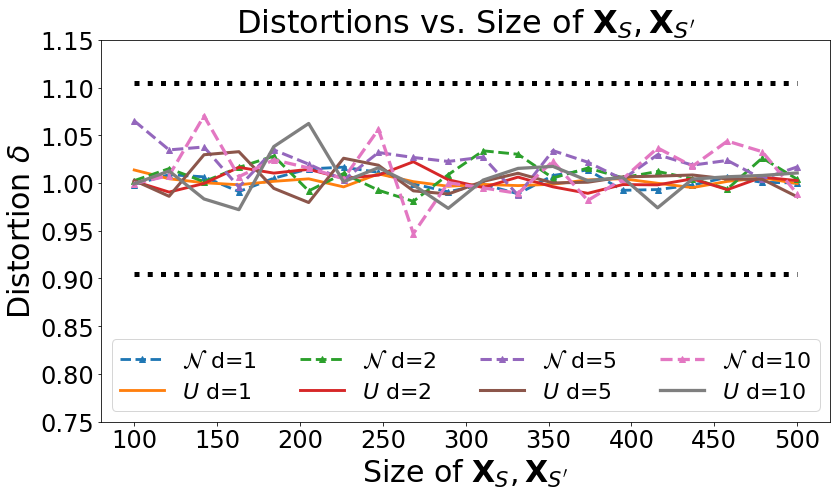

In [ ]:
plt.figure(figsize=(12, 7))


for i, d in enumerate(ds):
    plt.plot(s_values, distortion_mean_N[d], linestyle = 'dashed', marker='^', label= "$\mathcal{N}$ d="+str(d), linewidth=np.log(d+16))

    plt.plot(s_values, distortion_mean_U[d], linestyle = 'solid', label= "$U$ d="+str(d), linewidth=np.log(d+16))

plt.legend(ncol=4, loc='lower center', fontsize=22)
plt.ylabel("Distortion $\\delta$", fontsize=30)
plt.xlabel("Size of $\mathbf{X}_S, \mathbf{X}_{S'}$", fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.title("Distortions vs. Size of $\mathbf{X}_S, \mathbf{X}_{S'}$", fontsize=32)
plt.ylim(0.75, 1.15)
plt.hlines(xmin=s_values ,xmax = s_values[-1],  y=np.exp(0.1), linewidth=5, linestyle='dotted', color='k')
plt.hlines(xmin=s_values ,xmax = s_values[-1],  y=1.0/ (np.exp(0.1)), linewidth=5, linestyle='dotted', color='k')

plt.tight_layout()
plt.show()

## $\text{RV}(\mathbf{X}; \omega)/ \text{Vol} (\mathbf{X}) vs \omega $

In [24]:
rv_v_ratios = defaultdict(list)

d = 10
for _ in range(M):
    S1 = rand((s, d)) * (1 - 0) + 0 
    S2 = rand((s, d)) * (1 - 0) + 0 

    for omega in np.linspace(0.05, 0.5, 20):
        v1, v2, v_all = compute_volume(S1, S2, d)
        X_tilde, cubes = compute_X_tilde_and_counts(S1, omega)
        rv1 = compute_robust_volumes([X_tilde], [cubes])[0]

        rv_v_ratios[str(omega)].append(rv1 / v1)

ratio_data = []
for omega, rvs in rv_v_ratios.items():
    ratio_data.append(rvs)
ratio_data = np.asarray(ratio_data)

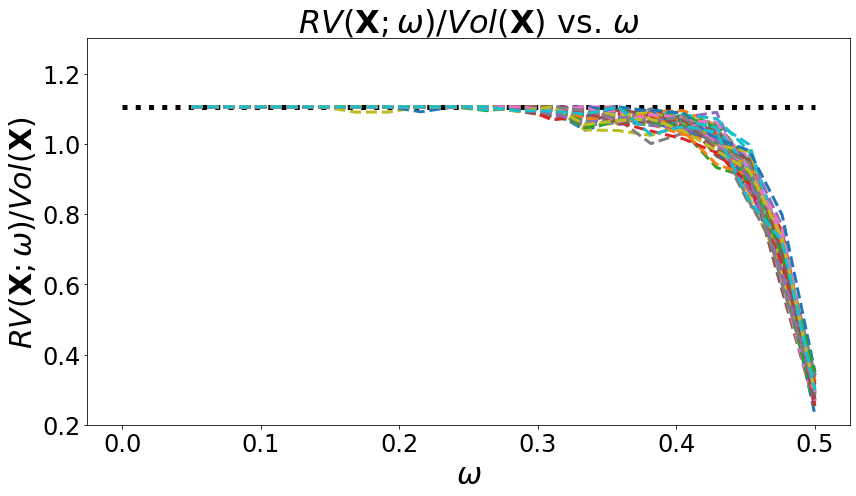

In [25]:
plt.figure(figsize=(12, 7))
omegas = np.linspace(0.05, 0.5, 20)

for i in range(M):
    plt.plot(omegas, ratio_data[:, i], linestyle = 'dashed', linewidth=3, label=i)

# plt.legend(ncol=10, loc='lower center', fontsize=12)
plt.ylabel("$RV(\\mathbf{X}; \\omega) / Vol(\\mathbf{X})$", fontsize=30)
plt.xlabel("$\\omega$", fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.title("$RV(\\mathbf{X}; \\omega)/Vol(\\mathbf{X})$ vs. $\\omega$", fontsize=32)
plt.hlines(xmin=0, xmax = 0.5,  y=np.exp(0.1), linewidth=5, linestyle='dotted', color='k')

plt.ylim(0.2, 1.3)

plt.tight_layout()
plt.show()

## Submodularity of $\log \text{Vol}()$

$   g(\mathbf{X}_{S\cup \mathbf{x}}) -   g(\mathbf{X}_{S}) \leq     g(\mathbf{X}_{S^+ \cup \mathbf{x}}) -   g(\mathbf{X}_{S^+})$
where 
$g = \log \text{Vol}()$ and $S \subseteq S^+$

In [9]:
ds = [5, 10, 15, 20]
M = 500
s_values = np.linspace(100, 500, 20)

success_rates_N = defaultdict(list)
success_rates_U = defaultdict(list)

for d in ds:
    for s in s_values:
        s = int(s)
        count_U = 0
        count_N = 0
        for _ in range(M):
            X = randn((s, d))

            S1 = X[np.random.choice(list(range(s)), int(0.3 * s))]
            x1 = X[np.random.choice(list(range(1)))]
            S1_bigger = torch.vstack([S1, x1])
            
            x2 = X[np.random.choice(list(range(1)))]
            S12 = torch.vstack([S1, x2])
            S1_bigger2 = torch.vstack([S1_bigger, x2])

            delta_S1 = torch.logdet(S12.T @ S12) - torch.logdet( S1.T @ S1) 
            delta_S1_bigger = torch.logdet( S1_bigger2.T @ S1_bigger2) - torch.logdet(S1_bigger.T @ S1_bigger ) 

            count_N += delta_S1 >= delta_S1_bigger


            X = rand((s, d))
            S1 = X[np.random.choice(list(range(s)), int(0.3 * s))]
            x1 = X[np.random.choice(list(range(1)))]
            S1_bigger = torch.vstack([S1, x1])
            
            x2 = X[np.random.choice(list(range(1)))]

            S12 = torch.vstack([S1, x2])
            S1_bigger2 = torch.vstack([S1_bigger, x2])

            delta_S1 = torch.logdet(S12.T @ S12) - torch.logdet( S1.T @ S1) 
            delta_S1_bigger = torch.logdet( S1_bigger2.T @ S1_bigger2) - torch.logdet(S1_bigger.T @ S1_bigger ) 

            count_U += delta_S1 >= delta_S1_bigger

        success_rates_N[d].append(count_N/ M)
        success_rates_U[d].append(count_U/ M)

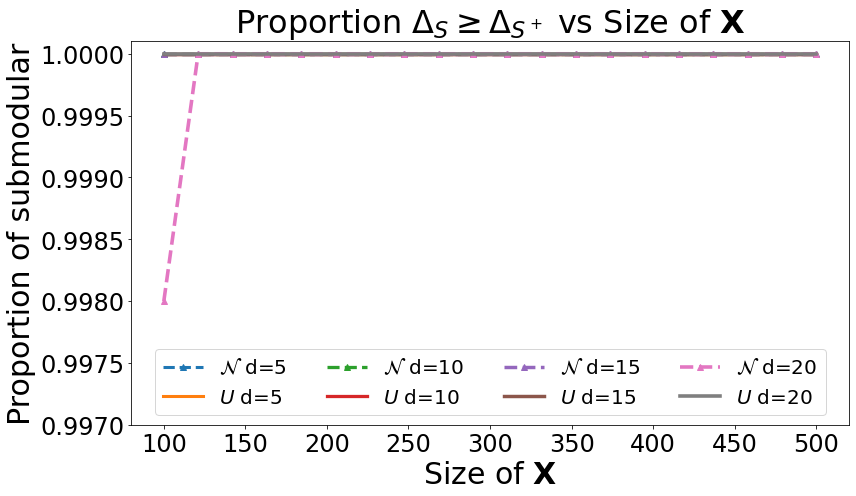

In [14]:
plt.figure(figsize=(12, 7))

for i, d in enumerate(ds):
    plt.plot(s_values, success_rates_N[d], linestyle = 'dashed', marker='^', label= "$\mathcal{N}$ d="+str(d), linewidth=np.log(d+16))

    plt.plot(s_values, success_rates_U[d], linestyle = 'solid', label= "$U$ d="+str(d), linewidth=np.log(d+16))

plt.legend(ncol=4, loc='lower center', fontsize=20)
plt.ylabel("Proportion of submodular", fontsize=30)
plt.xlabel("Size of $\mathbf{X}$", fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.title("Proportion $\Delta_{S} \geq \Delta_{S^+}$ vs Size of $\mathbf{X}$", fontsize=32)
plt.ylim(0.997)
# plt.ylim(0.75, 1.15)
# plt.hlines(xmin=s_values ,xmax = s_values[-1],  y=1.0/ (np.exp(0.1)), linewidth=5, linestyle='dotted', color='k')

plt.tight_layout()
plt.show()